
# <center> AttenSense - Inovative part
## <center> Shachar Reuvenny 200565679
## <center> Gal Blecher 201566304

Instruction for running the code:

change the pathes below and run the notebook.

warining: running time is about 10 hours.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
data_path = '/content/drive/MyDrive/Advanced ML final project/PAMAP2_Dataset/Protocol'
spectogram_path = "/content/drive/MyDrive/Advanced ML final project"
model_path = '/content/drive/MyDrive/Advanced ML final project'

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler, random_split
import torch
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import timeit
import seaborn as sn

###Preprocess

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# get the data of the subject and returns df with the relevant information
def prep_data(path, subgect):
  data = pd.read_csv(path, sep=' ', header=None)
  data.columns = pd.RangeIndex(1, len(data.columns) + 1) 
  data.drop(3, axis='columns', inplace=True)
  data = data.dropna()
  data = data[[1,2,22,23,24,28,29,30]]
  cols = {1: 'time_step', 2: 'activity_id', 22: 'acc_x', 23: 'acc_y', 24: 'acc_z', 28: 'gyro_x', 29: 'gyro_y', 30: 'gyro_z'}
  data = data.rename(columns=cols)
  # calculating norm
  data['acc_norm'] = np.sqrt(data['acc_x'] ** 2 + data['acc_y'] ** 2 + data['acc_z'] ** 2)
  data['gyro_norm'] = np.sqrt(data['gyro_x'] ** 2 + data['gyro_y'] ** 2 + data['gyro_z'] ** 2)
  data['User'] = f'{subject}'
  return data

In [6]:
# Perform preprocess for different subjects
subjects = ['101', '102', '105', '106', '107', '108']
path = data_path
data_list = []
for subject in subjects:
  data_list.append(prep_data(path + '/subject' + subject + '.dat', subject))

In [7]:
# Combine to one df
for d in range(len(data_list)):
  if d == 0:
    df = data_list[0]
  else:
    df = pd.concat([df, data_list[d]], axis=0, ignore_index=True)

#### Normalization

In [8]:
def normalize(df, cols): #list of columns
  df_t = (df[cols] - df[cols].mean()) / df[cols].std()
  df_norm = df.copy()
  df_norm[cols] = df_t
  
  return df_norm

In [9]:
data_norm = normalize(df, ['acc_norm', 'gyro_norm'])

#### Noise and Augmentation

In [10]:
def add_noise(df,cols, sigma=0.1):
  noise = np.random.normal(0, sigma, df[cols].shape)
  new_signal = df[cols] + noise
  df_noise = df.copy()
  df_noise[cols] = new_signal
  
  return df_noise

In [11]:
def augment(df, cols, num_of_inst):
  '''
    df should be inserted notmalized
    num_of_inst = num of instances to create from each instance
  '''
  aug_df = df.copy()
  for i in range(num_of_inst):
    np.random.seed(i)
    nois_data = add_noise(df, cols)
    nois_data['User'] = nois_data['User'] + f'{i}'
    aug_df= pd.concat([aug_df, nois_data], axis=0, ignore_index=True)

  return aug_df

In [12]:
data_aug = augment(data_norm, ['acc_norm', 'gyro_norm'], 6)

### Spectograms

In [13]:
initial_data = data_aug
unique_actions = np.unique(initial_data['activity_id'])
unique_users = np.unique(initial_data['User'])

In [14]:
dff = pd.DataFrame(columns=['activity','timstep', 'user','acc_spec','gyro_spec'])

In [15]:
dff.head()

,activity,timstep,user,acc_spec,gyro_spec


In [ ]:
# data_name = 'df_101'
# path = '/content/drive/MyDrive/Advanced ML final project/sepc_6_users'
for action in unique_actions:
  print('action: ', action)
  for user in unique_users:
    print('user: ', user)
    act_user_temp = initial_data[(initial_data['activity_id']==action) & (initial_data['User']==user)]
    NFFT = 25
    noverlap = int(0.25 * NFFT)
    fig = plt.figure(frameon=False)
    sr = 100
    timestep = 0
    for row in range(0, act_user_temp.shape[0], 150): # overlap of the data is 50%. not the hyperparameter of FFT.
      timestep += 1
      spec_acc, freqenciesFound_x, time, imageAxis_x = plt.specgram(act_user_temp['acc_norm'][row:row + 200], Fs=100, NFFT=NFFT, noverlap=noverlap, window=np.hamming(NFFT),cmap='viridis')
      spec_gyro, freqenciesFound_x, time, imageAxis_x = plt.specgram(act_user_temp['gyro_norm'][row:row + 200], Fs=100, NFFT=NFFT, noverlap=noverlap, window=np.hamming(NFFT),cmap='viridis')
      instance = pd.DataFrame({'activity':action, 'timstep':timestep, 'user':user, 'acc_spec':[spec_acc], 'gyro_spec':[spec_gyro]})
      dff = dff.append(instance, ignore_index=True)
    plt.close("all")

In [ ]:
# dff.to_pickle("/content/drive/MyDrive/Advanced ML final project/labeled_data_6_users_6_aug_2_sec.pkl")
dff.to_pickle(spectogram_path +  '/labeled_data_6_users_6_aug_2_sec.pkl')

In [51]:
df = pd.read_pickle(spectogram_path + '/labeled_data_6_users_6_aug_2_sec.pkl')

#### Activities filterring and making the labels sequencials

In [17]:
df = df[df['activity'].isin([1,2,3,4,5,6,7,12,13,16,17])]

In [18]:
df['activity'].loc[(df['activity']==12)] = 8
df['activity'].loc[(df['activity']==13)] = 9
df['activity'].loc[(df['activity']==16)] = 10
df['activity'].loc[(df['activity']==17)] = 0

In [19]:
df[df['activity'] == 4].shape

(14898, 5)

#### Balancing the data

In [20]:
df0 =  df[df['activity']==0]
df0_100 = df0.reset_index().iloc[:10_000]

df1 =  df[df['activity']==1]
df1_100 = df1.reset_index().iloc[:10_000]

df2 =  df[df['activity']==2]
df2_100 = df2.reset_index().iloc[:10_000]

df3 =  df[df['activity']==3]
df3_100 = df3.reset_index().iloc[:10_000]

df4 =  df[df['activity']==4]
df4_100 = df4.reset_index().iloc[:10_000]

df5 =  df[df['activity']==5]
df5_100 = df5.reset_index().iloc[:10_000]

df6 =  df[df['activity']==6]
df6_100 = df6.reset_index().iloc[:10_000]

df7 =  df[df['activity']==7]
df7_100 = df7.reset_index().iloc[:10_000]

In [21]:
df = pd.concat([df0_100, df1_100, df2_100, df3_100,df4_100,df5_100,df6_100,df7_100])

### Creating timesteps

In [22]:
loader_df_train = pd.DataFrame(columns=['id', 'input_5_timesteps', 'label'])
loader_df_test = pd.DataFrame(columns=['id', 'input_5_timesteps', 'label'])
id = 0
for user in unique_users:
  if user not in ('106', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '10610', '10611', '10612', '10613', '10614'):
    for action in unique_actions:
      ua_df = df[(df['user']==user) & (df['activity']==action)]
      for t in range(0, ua_df.shape[0], 5):
        vec_acc = ua_df.iloc[t:t+5]['acc_spec'].tolist()
        vec_gyro = ua_df.iloc[t:t+5]['gyro_spec'].tolist()
        vec_acc_gyro = [vec_acc] + [vec_gyro]
        instance = pd.DataFrame({'id': id, 'input_5_timesteps': [vec_acc_gyro], 'label': action})
        loader_df_train = loader_df_train.append(instance, ignore_index=True)
        id += 1
  elif user == '106':
    for action in unique_actions:
      ua_df = df[(df['user']==user) & (df['activity']==action)]
      for t in range(0, ua_df.shape[0], 5):
        vec_acc = ua_df.iloc[t:t+5]['acc_spec'].tolist()
        vec_gyro = ua_df.iloc[t:t+5]['gyro_spec'].tolist()
        vec_acc_gyro = [vec_acc] + [vec_gyro]
        instance = pd.DataFrame({'id': id, 'input_5_timesteps': [vec_acc_gyro], 'label': action})
        loader_df_test = loader_df_test.append(instance, ignore_index=True)
        id += 1
  else:
    continue


In [23]:
loader_df_test.shape

(275, 3)

In [24]:
# Convert to tensor and cleaning incompleted instances (less than 5 timesteps)
x = loader_df_train['input_5_timesteps']
id = []
label = []
tensor_input = []

for i in range(len(x)):
  try:
    x_tensor = torch.FloatTensor(x[i])
    # print(x_tensor.shape)
    if x_tensor.shape == torch.Size([2, 5, 13, 10]):
      tensor_input.append(x_tensor)
      label.append(loader_df_train['label'][i])
      id.append(loader_df_train['id'][i])

  except:
    print('*********',i)

********* 31
********* 68
********* 100
********* 129
********* 158
********* 186
********* 218
********* 245
********* 277
********* 314
********* 346
********* 375
********* 404
********* 432
********* 464
********* 491
********* 523
********* 560
********* 592
********* 621
********* 650
********* 678
********* 710
********* 737
********* 769
********* 806
********* 838
********* 867
********* 896
********* 924
********* 956
********* 983
********* 1015
********* 1052
********* 1084
********* 1113
********* 1142
********* 1170
********* 1202
********* 1229
********* 1261
********* 1298
********* 1330
********* 1359
********* 1388
********* 1416
********* 1448
********* 1475
********* 1507
********* 1544
********* 1576
********* 1605
********* 1634
********* 1662
********* 1694
********* 1721
********* 1760
********* 1791
********* 1822
********* 1856
********* 1898
********* 1910
********* 1943
********* 1981
********* 2020
********* 2051
********* 2082
********* 2116
********* 2158

In [25]:
# Convert to tensor and cleaning incompleted instances (less than 5 timesteps)
x_test = loader_df_test['input_5_timesteps']
id_test = []
label_test = []
tensor_input_test = []

for i in range(len(x_test)):
  try:
    x_tensor = torch.FloatTensor(x_test[i])
    # print(x_tensor.shape)
    if x_tensor.shape == torch.Size([2, 5, 13, 10]):
      tensor_input_test.append(x_tensor)
      label_test.append(loader_df_test['label'][i])
      id_test.append(loader_df_test['id'][i])

  except:
    print('*********',i)

********* 113
********* 180
********* 210
********* 238
********* 274


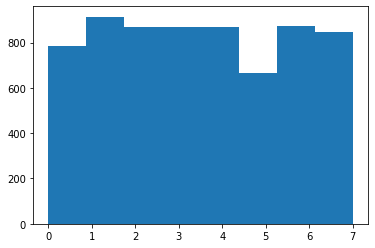

In [26]:
plt.hist(label, bins=8);

In [27]:
len(id), len(label), len(tensor_input)

(6689, 6689, 6689)

In [28]:
np.unique(label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([784, 914, 867, 868, 870, 665, 875, 846]))

### Dataloader

In [29]:
id = torch.tensor(id)
label = torch.tensor(label)
tensor_input = torch.stack(tensor_input)

id_test = torch.tensor(id_test)
label_test = torch.tensor(label_test)
tensor_input_test = torch.stack(tensor_input_test)

In [30]:
train_dataset = TensorDataset(id, tensor_input, label)
val_dataset = TensorDataset(id_test, tensor_input_test, label_test)
# train_size = train
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# print(f'{train_size} training samples')
# print(f'{val_size} validation samples')

In [31]:
torch.manual_seed(0)
batch_size = 1
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
            )
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
            )

#Network

torch.Size([13, 10])

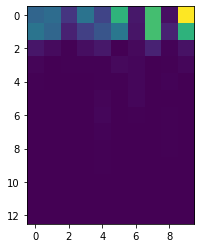

In [ ]:
instance = next(iter(train_dataloader))
acc_inst = instance[1][0][0][0]
gyro_inst = instance[1][0][1][0]
plt.imshow(gyro_inst);
acc_inst.shape

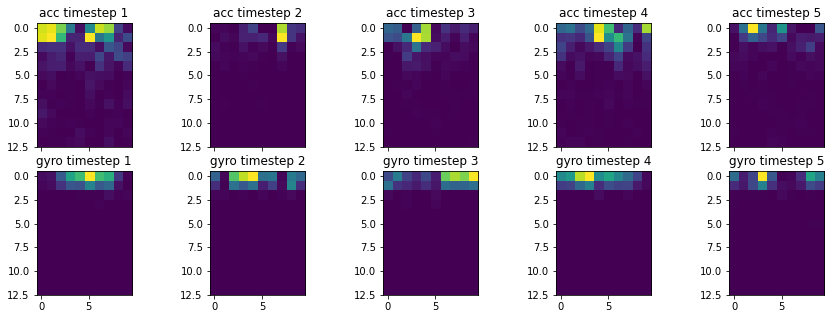

In [ ]:
fig, axes = plt.subplots(2, 5, sharex=True, sharey=False, figsize=(15,5))
instance = next(iter(train_dataloader))
for i in range(5):
    axes[0,i].imshow(instance[1][0][0][i])
    axes[0,i].set_title(f'acc timestep {i+1}')
for i in range(5):
    axes[1,i].imshow(instance[1][0][1][i])
    axes[1,i].set_title(f'gyro timestep {i+1}')

In [32]:
torch.manual_seed(0)
class CNN_acc(nn.Module):
  def __init__(self):
    super(CNN_acc, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, (1,3), padding='same')
    self.conv2 = nn.Conv2d(32, 32, (1,3), padding='same')
    self.conv3 = nn.Conv2d(32, 64, (1,3), padding='same')
    self.conv4 = nn.Conv2d(64, 64, (1,3), padding='same')
    self.fc = nn.Linear(2048, 128)
    torch.nn.init.xavier_normal(self.fc.weight)
    torch.nn.init.xavier_normal(self.conv1.weight)
    torch.nn.init.xavier_normal(self.conv2.weight)
    torch.nn.init.xavier_normal(self.conv3.weight)
    torch.nn.init.xavier_normal(self.conv4.weight)


  def forward(self, x):
    # print('x.shape 1: ', x.shape)
    x = F.relu(self.conv1(x))
    # print('x.shape 2: ', x.shape)
    x = F.relu(F.max_pool2d(self.conv2(x), (1,2)))
    # print('x.shape 3: ', x.shape)
    x = F.relu(self.conv3(x))
    # print('x.shape 4: ', x.shape)
    x = F.relu(F.max_pool2d(self.conv4(x), (1,2)))
    # print('x.shape 5: ', x.shape)
    x = torch.flatten(x, start_dim=1)
    # print('x.shape 6: ', x.shape)
    x = self.fc(x)
    # print('x.shape 7: ', x.shape)

    return x

In [33]:
torch.manual_seed(0)
class CNN_gyro(nn.Module):
  def __init__(self):
    super(CNN_gyro, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, (1,3), padding='same')
    self.conv2 = nn.Conv2d(32, 32, (1,3), padding='same')
    self.conv3 = nn.Conv2d(32, 64, (1,3), padding='same')
    self.conv4 = nn.Conv2d(64, 64, (1,3), padding='same')
    self.fc = nn.Linear(2048, 128)
    torch.nn.init.xavier_normal(self.fc.weight)
    torch.nn.init.xavier_normal(self.conv1.weight)
    torch.nn.init.xavier_normal(self.conv2.weight)
    torch.nn.init.xavier_normal(self.conv3.weight)
    torch.nn.init.xavier_normal(self.conv4.weight)

  def forward(self, x):
    # print('x.shape 1: ', x.shape)
    x = F.relu(self.conv1(x))
    # print('x.shape 2: ', x.shape)
    x = F.relu(F.max_pool2d(self.conv2(x), (1,2)))
    # print('x.shape 3: ', x.shape)
    x = F.relu(self.conv3(x))
    # print('x.shape 4: ', x.shape)
    x = F.relu(F.max_pool2d(self.conv4(x), (1,2)))
    # print('x.shape 5: ', x.shape)
    x = torch.flatten(x, start_dim=1)
    # print('x.shape 6: ', x.shape)
    x = self.fc(x)

    return x

In [34]:
class Additive_Attention_1(nn.Module):
  def __init__(self):
    super(Additive_Attention_1, self).__init__()
    self.w = torch.rand(2, 1)
    self.w = torch.nn.Parameter(torch.nn.init.xavier_uniform_(self.w))
    self.b = torch.zeros(1)
    self.b = torch.nn.Parameter(self.b)
    self.v = torch.rand(128, 1)
    self.v = torch.nn.Parameter(torch.nn.init.xavier_uniform_(self.v))
    self.new_linear = torch.nn.Linear(128, 128)

  def forward(self, x):
    # print('x.shape: ', x.shape)
    temp_o = self.new_linear(torch.squeeze(x, 1))
    # print('temp_o.shape: ', temp_o.shape)
    o = torch.tanh(temp_o)
    # print('temp_o.shape: ', temp_o.shape)
    temp_w = o @ self.v
    # print('temp_w.shape: ', temp_w.shape)
    w = F.softmax(temp_w).reshape(5,1,2)
    # print('w.shape: ', w.shape)
    context = torch.bmm(w, temp_o)
    # print('context.shape: ',context.shape)
    
    return context

In [35]:
class Additive_Attention_2(nn.Module):
  def __init__(self):
    super(Additive_Attention_2, self).__init__()
    self.w = torch.rand(5, 1)
    self.w = torch.nn.Parameter(torch.nn.init.xavier_uniform_(self.w))
    self.b = torch.zeros(1)
    self.b = torch.nn.Parameter(self.b)
    self.v = torch.rand(64, 1)
    self.v = torch.nn.Parameter(torch.nn.init.xavier_uniform_(self.v))
    self.new_linear = torch.nn.Linear(128, 64)

  def forward(self, x):
    # print('x.shape: ', x.shape)
    temp_o = self.new_linear(torch.squeeze(x, 1))
    # print('temp_o.shape: ', temp_o.shape)
    o = torch.tanh(temp_o)
    # print('temp_o.shape: ', temp_o.shape)
    temp_w = o @ self.v
    # print('temp_w.shape: ', temp_w.shape)
    w = F.softmax(temp_w)
    # print('w.shape: ', w.shape)
    context = w.T @ temp_o
    # print('context.shape: ',context.shape)
    
    return context

In [36]:
class Multihead(nn.Module):
  def __init__(self):
    super(Multihead, self).__init__()
    self.attn = nn.MultiheadAttention(128, 1, batch_first=True)
    self.norm = nn.BatchNorm1d(num_features=128)
    self.fc1 = nn.Linear(128, 128)
    self.fc2 = nn.Linear(128, 128)

  def forward(self, x):
    x_res = x.clone() # residual
    # print('x_res: ', x_res.shape)
    x = self.attn(x, x, x)[0]
    # print('x1: ', x.shape)
    x = torch.add(x, x_res)
    # print('x2: ', x.shape)
    x_res = x.clone()
    # print('x2_res: ', x.shape)
    x = F.relu(self.fc1(x))
    # print('x3: ', x.shape)
    x = self.fc2(x)
    # print('x4: ', x.shape)
    x = torch.add(x, x_res)
    # print('x5: ', x.shape)
    
    return x

In [37]:
class Attnsense_Attention(nn.Module):
  def __init__(self):
    super(Attnsense_Attention, self).__init__()
    self.conv_acc = CNN_acc()
    self.conv_gyro = CNN_gyro()
    self.additive_attn_1 = Additive_Attention_1()
    self.additive_attn_2 = Additive_Attention_2()
    self.multihead_1 = Multihead()
    self.multihead_2 = Multihead()
    self.multihead_3 = Multihead()
    self.fc = nn.Linear(64, 8)


  def forward(self, x):
    # print(x[0][0].shape)
    acc_input = x[0][0].reshape(5,1,1,130)
    gyro_input = x[0][1].reshape(5,1,1,130)
    conv_acc_out = self.conv_acc.forward(acc_input)
    conv_gyro_out = self.conv_gyro.forward(gyro_input)
    # print('conv_acc_out: ', conv_acc_out.shape)
    zipped = torch.stack([conv_acc_out, conv_gyro_out], dim=1)
    #[5,2,128]
    # print('zipped.shape: ', zipped.shape)
    additive_attn_1_out = self.additive_attn_1(zipped)
    # print('additive_attn_1_out.shape: ', additive_attn_1_out.shape)
    #[5,1,128]
    multihead_1_out = self.multihead_1(additive_attn_1_out)
    # print('multihead_1_out.shape: ', multihead_1_out.shape)
    multihead_2_out = self.multihead_2(multihead_1_out)
    # print('multihead_2_out.shape: ', multihead_2_out.shape)
    multihead_3_out = self.multihead_3(multihead_2_out)
    # print('multihead_3_out.shape: ', multihead_3_out.shape)
    #[5,1,64]
    additive_attn_2_out = self.additive_attn_2(multihead_3_out)
    # print('additive_attn_2_out: ', additive_attn_2_out.shape)
    #[1,128]
    x = self.fc(additive_attn_2_out)
    # print('x.shape: ', x.shape)
    x = F.softmax(x, dim=1)

    return x

In [38]:
def loss_calc(net, loader, criterion):
  with torch.no_grad():
    tot_loss = 0
    for i, data in enumerate(loader, 0):
      _, inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      tot_loss += loss.item()
      
  return tot_loss / (i + 1)

In [39]:
def save_vectors(vectors, name):
  a_file = open(f'{name}.pkl', 'wb')
  pickle.dump(vectors, a_file)
  a_file.close()

#### Training

In [ ]:
torch.manual_seed(0)

def train(net, train_loader, test_loader, epochs):
    lowest_loss = 0
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum=0.9) # best learning rate was 0.00005
    start_time = timeit.default_timer()
    train_loss = {}
    test_loss = {}
    for epoch in range(epochs):
        running_loss = 0.0
        print(epoch)
        for i, data in enumerate(train_loader, 0):
            _, inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device) 

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i + 1) % 100 == 0:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        train_loss[epoch + 1] = loss_calc(net, train_loader, criterion)

        test_loss[epoch + 1] = loss_calc(net, test_loader, criterion) 
        print(f'Epoch = {epoch + 1}, train loss = {train_loss[epoch + 1]}')
        print(f'Epoch = {epoch + 1}, test loss = {test_loss[epoch + 1]}')

        if test_loss[epoch + 1] < 1.7 and lowest_loss == 0:
          lowest_loss = test_loss[epoch + 1]
          torch.save(net.state_dict(), model_path + '/model_with_attentions_final_3_6_aug_106_test')
          save_vectors(train_loss, model_path + '/train_loss_attention_final_3_6_aug_106_test')
          save_vectors(test_loss, model_path + '/test_loss_attention_final_3_6_aug_106_test')

        if test_loss[epoch + 1] < lowest_loss:
          lowest_loss = test_loss[epoch + 1]
          torch.save(net.state_dict(), model_path + '/model_with_attentions_final_3_6_aug_106_test')
          save_vectors(train_loss, model_path + '/train_loss_attention_final_3_6_aug_106_test')
          save_vectors(test_loss, model_path + '/test_loss_attention_final_3_6_aug_106_test')

        if test_loss[epoch+1] < 1.75:
          optimizer = torch.optim.SGD(net.parameters(), lr = 0.00001, momentum=0.9) 
        if test_loss[epoch+1] < 1.65:
          optimizer = torch.optim.SGD(net.parameters(), lr = 0.000001, momentum=0.9) 
    end_time = timeit.default_timer()

    print(f'Finish Training + Testing after: {end_time - start_time}')
    return train_loss, test_loss

In [ ]:
net = Attnsense_Attention().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  


In [ ]:
Intrain_loss, test_loss = train(net, train_dataloader, validation_dataloader, 1000)

In [ ]:
net = Attnsense()
print(net.forward)

<bound method Attnsense.forward of Attnsense(
  (conv_acc): CNN_acc(
    (conv1): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv3): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv4): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (fc): Linear(in_features=2048, out_features=128, bias=True)
  )
  (conv_gyro): CNN_gyro(
    (conv1): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv3): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (conv4): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (fc): Linear(in_features=2048, out_features=128, bias=True)
  )
  (attn1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (gru): GRU(128, 64, num_l

### Evaluation

In [40]:
def load_vectors(path):
    t = open(path, 'rb')
    output = pickle.load(t)
    t.close()
    
    return output

In [41]:
train_loss = load_vectors(model_path + '/train_loss_attention_final_3_6_aug_106_test.pkl')
test_loss = load_vectors(model_path + '/test_loss_attention_final_3_6_aug_106_test.pkl')

In [42]:
min(test_loss.values())

1.5188516677542125

In [43]:
def mean_k(dict_values, k):
  val = np.array(list(dict_values))
  out = []
  for i in range(val.shape[0] - k):
    out.append(val[i:i+k].mean())
  return out

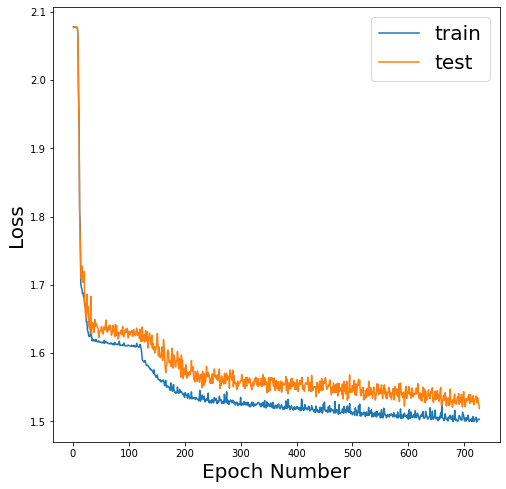

In [44]:
plt.figure(figsize = (8, 8))
plt.plot(list(train_loss.keys()), list(train_loss.values()), label = 'train')
plt.plot(list(test_loss.keys()), list(test_loss.values()), label = 'test')
# plt.plot(mean_k(test_loss.values(), 20), label = 'mean 20', linewidth=3, linestyle='--')
plt.xlabel('Epoch Number', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.legend(fontsize = 20)

In [45]:
model = Attnsense_Attention()
model.load_state_dict(torch.load(model_path + '/model_with_attentions_final_3_6_aug_106_test'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  


<All keys matched successfully>

In [46]:
def acc(net, loader):
    correct = 0
    total = 0
    all_preds = torch.tensor([])
    all_lab = torch.tensor([])
    with torch.no_grad():
        for data in loader:
            _, inputs, labels = data
            inputs = inputs
            labels = labels
            outputs = net(inputs).reshape(1,-1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds = torch.cat((all_preds, predicted) ,dim=0)
            all_lab = torch.cat((all_lab, labels) ,dim=0)
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    return all_lab, all_preds

In [47]:
y_true, y_pred = acc(model, validation_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the test images: 74 %


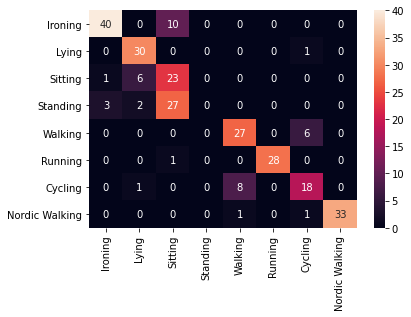

In [48]:
activities = ['Ironing', 'Lying', 'Sitting', 'Standing', 'Walking', 'Running', 'Cycling', 'Nordic Walking']
sn.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred), columns=activities, index=activities), annot=True)